# Project Info

## Data source

The dataset used in this project is a curated collection of mental health statements compiled from various sources by Kaggle user Suchintika Sarkar.

Kaggle version of the dataset:
https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health

## Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, EarlyStoppingCallback

c:\Users\nikko\Documents\Python Projects\mentalhealth-sentiment-app\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Data Load

In [3]:
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
csv_files = glob.glob(os.path.join(path, "*.csv"))

In [4]:
df = pd.read_csv(csv_files[0])
df = df[['statement', 'status']]
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


# Data Preparation

### Row Count and Nulls

The dataset has already been cleaned, but rows with null statements should be dropped to prevent errors

In [5]:
row_count = df.shape[0]
df = df.dropna(subset=['statement'])
new_row_count = df.shape[0]

print(f"Row count before cleaning: {row_count}\nRow count after dropping null statement: {new_row_count}")

Row count before cleaning: 53043
Row count after dropping null statement: 52681


## Exploratory Data Analysis

### Status Distribution

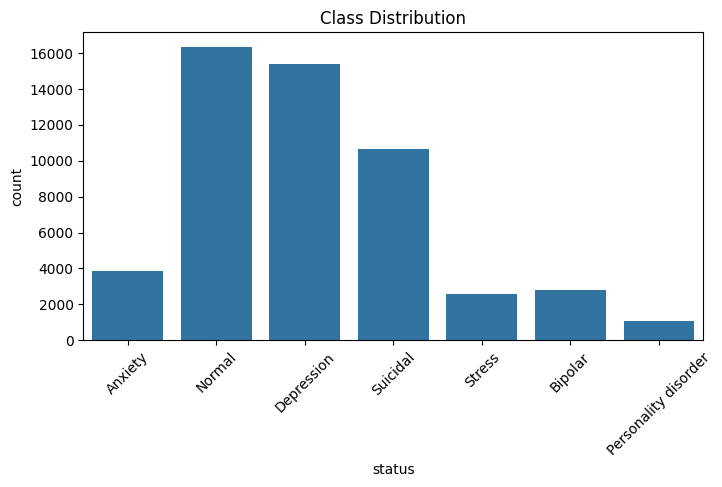

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='status')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

The top two categories contain significantly more samples than the others, which may affect predictive performance across all classes.

### Word Count

In [7]:
cap = 300  # or 500
df['text_length'] = df['statement'].apply(lambda x: len(x.split()))
df['text_length_capped'] = df['text_length'].clip(upper=cap)

In [8]:
min_length = df['text_length'].min()
max_length = df['text_length'].max()
median_length = df['text_length'].median()
mean_length = df['text_length'].mean()

# Display results
print(f"Minimum text length: {min_length} words")
print(f"Maximum text length: {max_length} words")
print(f"Median text length: {median_length} words")
print(f"Average text length: {mean_length:.2f} words")

Minimum text length: 1 words
Maximum text length: 6300 words
Median text length: 62.0 words
Average text length: 113.16 words


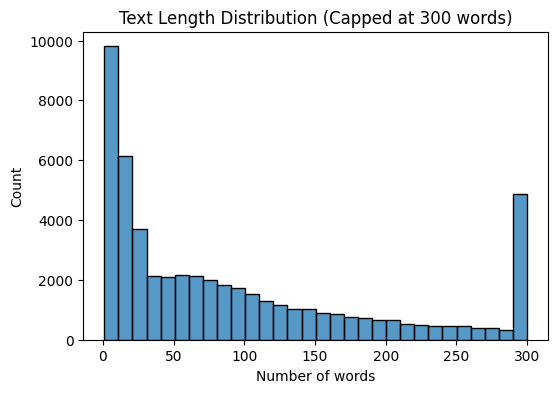

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(df['text_length_capped'], bins=30)
plt.title(f"Text Length Distribution (Capped at {cap} words)")
plt.xlabel("Number of words")
plt.show()


The majority of the samples have a word count below 25. A long-tail distribution is expected in open-text datasets.

In [10]:
df.groupby('status')['text_length'].agg(['min', 'max', 'median', 'mean']).round(1)

,min,max,median,mean
status,,,,
Anxiety,1,1592,102.0,143.8
Bipolar,4,4804,129.0,176.2
Depression,1,4239,113.0,168.0
Normal,1,255,10.0,17.2
Personality disorder,5,5419,137.0,179.3
Stress,1,1606,87.0,114.6
Suicidal,1,6300,92.0,146.4


Based on the stats:
- Normal texts are shorter
- Clinical categories are longer and variable
- The signifficant difference in length suggests that struggling people tend to write more detailed statements

## Modeling

### Target Encoding

In [11]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['status'])

num_classes = len(le.classes_)
print(le.classes_)

['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


### TF-IDF

Due to sample imbalance and varying word counts across categories, we will apply class weights to reduce bias toward the Normal category and strengthen representation of the smaller ones

In [12]:
class_weight = {
    0: 1.0,   # Anxiety
    1: 1.0,   # Bipolar
    2: 1.2,   # Depression
    3: 0.6,   # Normal
    4: 1.8,   # Personality disorder
    5: 1.4,   # Stress
    6: 1.5    # Suicidal
}

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['statement'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [14]:
baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=30000,
        ngram_range=(1,3),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
        lowercase=True
    )),
    ('clf', LogisticRegression(
        max_iter=2000,
        solver='lbfgs',
        n_jobs=-1,
        class_weight=class_weight
    ))
])

In [15]:
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

c:\Users\nikko\Documents\Python Projects\mentalhealth-sentiment-app\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


                      precision    recall  f1-score   support

             Anxiety       0.87      0.70      0.77       768
             Bipolar       0.92      0.66      0.77       556
          Depression       0.70      0.74      0.72      3081
              Normal       0.90      0.93      0.92      3269
Personality disorder       0.84      0.55      0.67       215
              Stress       0.60      0.53      0.56       517
            Suicidal       0.68      0.74      0.71      2131

            accuracy                           0.78     10537
           macro avg       0.79      0.69      0.73     10537
        weighted avg       0.78      0.78      0.78     10537



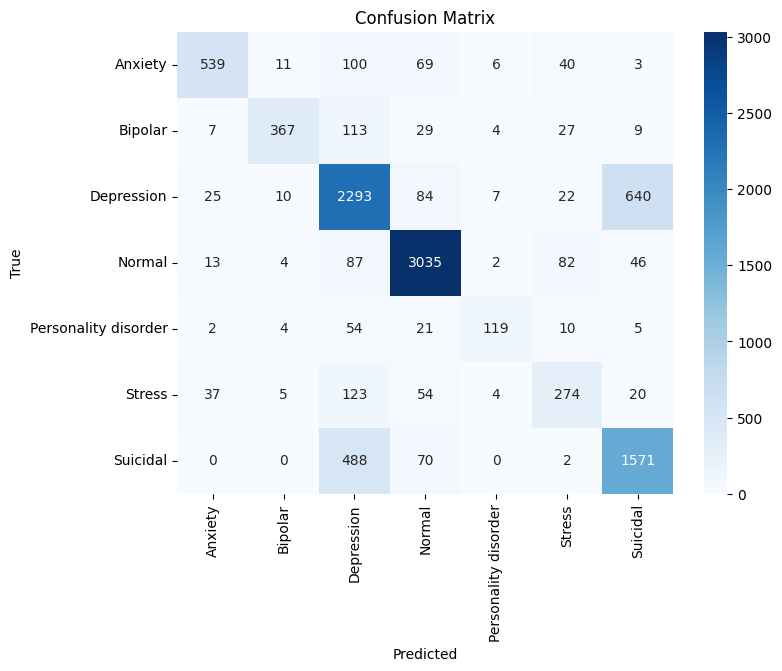

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

The model struggles classifying between Depression and Suicidal, possibly due to overlapping language.

### DistilBERT

In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [18]:
def tokenize(batch):
    return tokenizer(
        batch['statement'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

In [19]:
train_df = pd.DataFrame({'statement': X_train, 'label': y_train})
test_df  = pd.DataFrame({'statement': X_test,  'label': y_test})

train_ds = Dataset.from_pandas(train_df)
test_ds  = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.remove_columns(['statement'])
test_ds  = test_ds.remove_columns(['statement'])

Map: 100%|██████████| 10537/10537 [00:01<00:00, 10005.12 examples/s]


In [20]:
train_ds.set_format("torch")
test_ds.set_format("torch")

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_classes
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none"
)

In [23]:
model_path = "model_state.pt"

if os.path.exists(model_path):
    print("✅ Found model_state.pt — loading weights...")
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=num_classes
    )
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
else:
    print("🚀 model_state.pt not found — training from scratch...")
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=num_classes
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer
    )
    trainer.train()

    torch.save(model.state_dict(), model_path)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer
)

✅ Found model_state.pt — loading weights...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nikko\AppData\Local\Temp\ipykernel_14096\3270688626.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
preds = trainer.predict(test_ds)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

c:\Users\nikko\Documents\Python Projects\mentalhealth-sentiment-app\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                      precision    recall  f1-score   support

             Anxiety       0.89      0.88      0.88       768
             Bipolar       0.87      0.85      0.86       556
          Depression       0.77      0.81      0.79      3081
              Normal       0.95      0.95      0.95      3269
Personality disorder       0.79      0.66      0.72       215
              Stress       0.71      0.80      0.76       517
            Suicidal       0.75      0.69      0.72      2131

            accuracy                           0.83     10537
           macro avg       0.82      0.80      0.81     10537
        weighted avg       0.83      0.83      0.83     10537



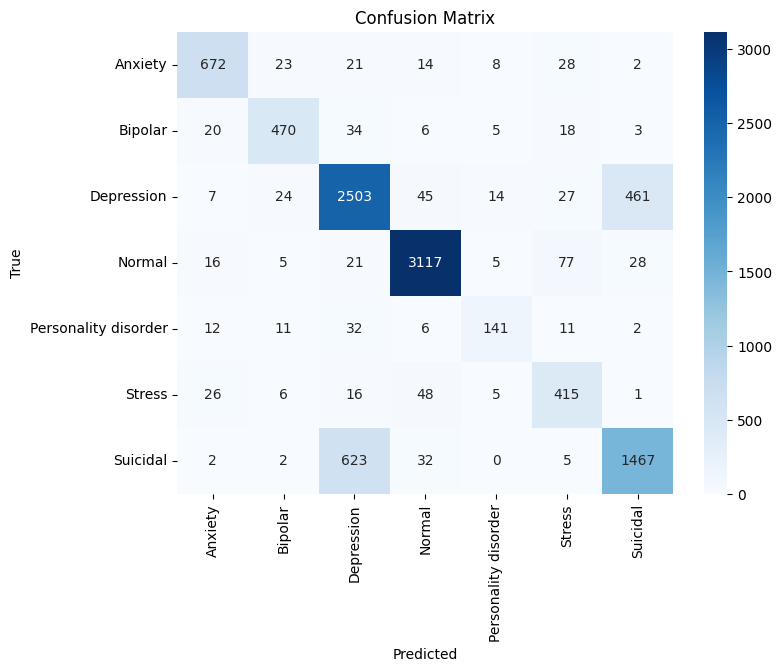

In [25]:
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

While the overall performance improved, the newer model still struggles to classify between Depression and Suicidal.

In [26]:
results_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})

results_df["true_label_name"] = le.inverse_transform(results_df["true_label"])
results_df["pred_label_name"] = le.inverse_transform(results_df["pred_label"])

misclassified = results_df[results_df["true_label"] != results_df["pred_label"]]

print("Number of misclassified samples:", len(misclassified))

Number of misclassified samples: 1752


In [27]:
misclassified.head()

,text,true_label,pred_label,true_label_name,pred_label_name
51302,I can't tell if I'm jealous of other people I ...,4,2,Personality disorder,Depression
26847,"Pog, if you are reading this, I am probably de...",6,2,Suicidal,Depression
10355,I am sorry this is a terribly convoluted strea...,6,2,Suicidal,Depression
10208,... I am on my last leg. My heart aches and it...,6,2,Suicidal,Depression
26739,My doc prescribed a med to supplement the snri...,2,1,Depression,Bipolar


## Secondary Model

To improve the results, a new model will be trained to better distinguish Depression from Suicidal remarks.

### Filter and prepare dataset

In [28]:
depr_code = le.transform(["Depression"])[0]
suic_code = le.transform(["Suicidal"])[0]

binary_df = df[df["label"].isin([depr_code, suic_code])].copy()

binary_df["binary_label"] = binary_df["label"].map({
    depr_code: 0,   # Depression → 0
    suic_code: 1    # Suicidal → 1
})

In [29]:
train_df_bin, eval_df_bin = train_test_split(
    binary_df[["statement", "binary_label"]],
    test_size=0.2,
    random_state=42,
    stratify=binary_df["binary_label"]
)

In [30]:
binary_train_ds = Dataset.from_pandas(train_df_bin)
binary_eval_ds  = Dataset.from_pandas(eval_df_bin)

### Tokenize

In [31]:
binary_train_ds = binary_train_ds.map(tokenize, batched=True)
binary_eval_ds  = binary_eval_ds.map(tokenize, batched=True)

binary_train_ds = binary_train_ds.rename_column("binary_label", "labels")
binary_eval_ds  = binary_eval_ds.rename_column("binary_label", "labels")

binary_train_ds = binary_train_ds.remove_columns(["statement"])
binary_eval_ds  = binary_eval_ds.remove_columns(["statement"])

binary_train_ds.set_format("torch")
binary_eval_ds.set_format("torch")

Map: 100%|██████████| 5212/5212 [00:00<00:00, 8726.97 examples/s]


### Training

In [32]:
binary_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
binary_training_args = TrainingArguments(
    output_dir="./binary_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./binary_logs",
    report_to="none"
)

In [34]:
binary_model_path = "binary_model_state.pt"

if os.path.exists(binary_model_path):
    print("✅ Found binary_model_state.pt — loading weights...")
    binary_model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    )
    state_dict = torch.load(binary_model_path, map_location=device)
    binary_model.load_state_dict(state_dict)
else:
    print("🚀 binary_model_state.pt not found — training from scratch...")
    binary_model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    )

    binary_trainer = Trainer(
        model=binary_model,
        args=binary_training_args,
        train_dataset=binary_train_ds,
        eval_dataset=binary_eval_ds,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    binary_trainer.train()

    torch.save(binary_model.state_dict(), binary_model_path)

binary_trainer = Trainer(
    model=binary_model,
    args=binary_training_args,
    train_dataset=binary_train_ds,
    eval_dataset=binary_eval_ds,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

✅ Found binary_model_state.pt — loading weights...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nikko\AppData\Local\Temp\ipykernel_14096\1513537623.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  binary_trainer = Trainer(


In [35]:
preds = binary_trainer.predict(binary_eval_ds)
y_pred = np.argmax(preds.predictions, axis=1)

y_true = np.array(binary_eval_ds["labels"])

print(classification_report(y_true, y_pred, target_names=["Depression", "Suicidal"]))

c:\Users\nikko\Documents\Python Projects\mentalhealth-sentiment-app\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

  Depression       0.85      0.79      0.82      3081
    Suicidal       0.73      0.80      0.76      2131

    accuracy                           0.79      5212
   macro avg       0.79      0.80      0.79      5212
weighted avg       0.80      0.79      0.80      5212



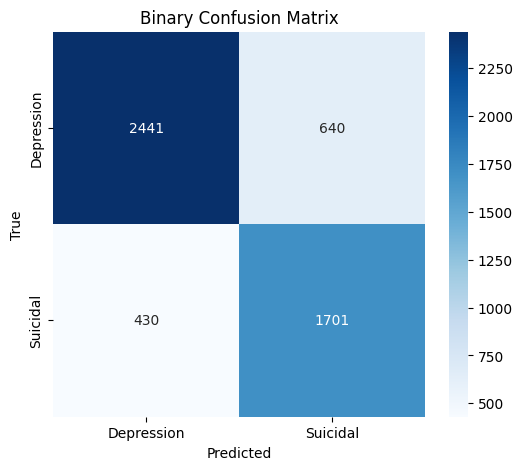

In [36]:
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Depression", "Suicidal"],
            yticklabels=["Depression", "Suicidal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Binary Confusion Matrix")
plt.show()

## Merged Model

1. Predict all class.
2. Run all Depression/Suicidal predictions on the binary model.

In [37]:
multiclass_preds = trainer.predict(test_ds)
multiclass_labels = np.argmax(multiclass_preds.predictions, axis=1)

depr_code = le.transform(["Depression"])[0]
suic_code = le.transform(["Suicidal"])[0]
target_codes = [depr_code, suic_code]

refine_indices = [i for i, label in enumerate(multiclass_labels) if label in target_codes]

c:\Users\nikko\Documents\Python Projects\mentalhealth-sentiment-app\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [38]:
if refine_indices:
    refine_texts = test_df.iloc[refine_indices]["statement"].tolist()
    refine_encodings = tokenizer(refine_texts, truncation=True, padding=True)
    refine_ds = Dataset.from_dict(refine_encodings)

    binary_preds = binary_trainer.predict(refine_ds)
    binary_labels = np.argmax(binary_preds.predictions, axis=1)

    for j, idx in enumerate(refine_indices):
        multiclass_labels[idx] = depr_code if binary_labels[j] == 0 else suic_code

y_true = test_df["label"].values

print(classification_report(y_true, multiclass_labels, target_names=le.classes_))

c:\Users\nikko\Documents\Python Projects\mentalhealth-sentiment-app\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                      precision    recall  f1-score   support

             Anxiety       0.89      0.88      0.88       768
             Bipolar       0.87      0.85      0.86       556
          Depression       0.87      0.79      0.83      3081
              Normal       0.95      0.95      0.95      3269
Personality disorder       0.79      0.66      0.72       215
              Stress       0.71      0.80      0.76       517
            Suicidal       0.76      0.87      0.81      2131

            accuracy                           0.86     10537
           macro avg       0.84      0.83      0.83     10537
        weighted avg       0.87      0.86      0.86     10537



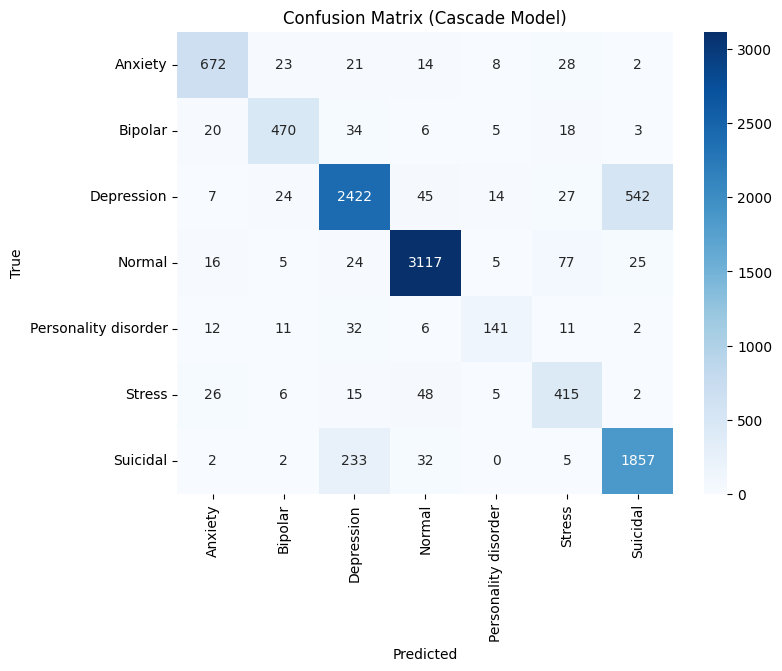

In [39]:
cm = confusion_matrix(y_true, multiclass_labels, labels=range(len(le.classes_)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Cascade Model)")
plt.show()

The model’s overall performance increased by 10%, with a notable improvement in recall for the Suicidal class.

## 2-Step Predictor Function

In [40]:
def predict_text(texts):
    if isinstance(texts, str):
        texts = [texts]

    encodings = tokenizer(texts, truncation=True, padding=True)
    ds = Dataset.from_dict(encodings)
    preds = trainer.predict(ds)
    multiclass_labels = preds.predictions.argmax(-1)

    depr_code = le.transform(["Depression"])[0]
    suic_code = le.transform(["Suicidal"])[0]
    target_codes = [depr_code, suic_code]

    refine_indices = [i for i, label in enumerate(multiclass_labels) if label in target_codes]

    if refine_indices:
        refine_texts = [texts[i] for i in refine_indices]
        refine_encodings = tokenizer(refine_texts, truncation=True, padding=True)
        refine_ds = Dataset.from_dict(refine_encodings)

        binary_preds = binary_trainer.predict(refine_ds)
        binary_labels = binary_preds.predictions.argmax(-1)

        for j, idx in enumerate(refine_indices):
            multiclass_labels[idx] = depr_code if binary_labels[j] == 0 else suic_code

    return [le.classes_[i] for i in multiclass_labels]